# Stack the FFI counts across campaigns

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.utils.console import ProgressBar
import logging
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import astropy.visualization
from fast_histogram import histogram1d

In [4]:
df = pd.read_csv('../../k2-target-index/k2-target-pixel-files.csv.gz')

In [5]:
! ls /Volumes/Truro/ffi/archive.stsci.edu/pub/k2/ffi/ |tail

ktwo2017162122209-c14_ffi-uncert.fits
ktwo2017203170143-c14_ffi-cal.fits
ktwo2017203170143-c14_ffi-uncert.fits
wcs-ktwo2014070234206-c00_ffi-cal.fits
wcs-ktwo2014074233223-c00_ffi-cal.fits
wcs-ktwo2014110010101-c00_ffi-cal.fits
wcs-ktwo2014157010055-c01_ffi-cal.fits
wcs-ktwo2014203150825-c01_ffi-cal.fits
wcs-ktwo2014240042843-c02_ffi-cal.fits
wcs-ktwo2014294030900-c02_ffi-cal.fits


In [6]:
hdu_ffi = fits.open('/Volumes/Truro/ffi/archive.stsci.edu/pub/k2/ffi/ktwo2014074233223-c00_ffi-cal.fits')
campaign = 0
#hdu_counts = fits.open('/Volumes/burlingame/FFI_counts/C{}_FFI_mask.fits'.format(str(campaign)))
hdu_counts = fits.open('../data/FFI_counts/C0_FFI_mask.fits')

In [7]:
len(hdu_counts)

85

In [8]:
for i in np.arange(1, 85):
    print(hdu_counts[i].data.sum(), end = ' ')

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 57996.0 48034.0 32990.0 45028.0 77150.0 54623.0 54251.0 60106.0 45527.0 58709.0 53755.0 69560.0 41534.0 42641.0 53557.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

In [9]:
#df[df.url.str.contains('ktwo202086810-c00_lpd-targ.fits.gz')].T

In [10]:
165183

165183

In [11]:
mod_out = 'MOD.OUT 10.1'
counts = hdu_counts[mod_out].data
data_raw = hdu_ffi[mod_out].data

In [12]:
np.min(data_raw)

-340.04855

In [13]:
delta = -1.0*np.min(data_raw) + 100

In [14]:
data = data_raw + delta

In [15]:
logdat = np.log10(data)

In [16]:
minmax = astropy.visualization.MinMaxInterval()

vmin, vmax = minmax.get_limits(logdat)

x = np.linspace(vmin, vmax, 200)
y = histogram1d(logdat.reshape(-1), bins=200, range=(vmin, vmax))

In [17]:
good_interval = astropy.visualization.AsymmetricPercentileInterval(10, 95.0)
vmin, vmax = good_interval.get_limits(logdat)

In [18]:
norm = astropy.visualization.ImageNormalize(vmin=10**vmin, vmax=10**vmax)

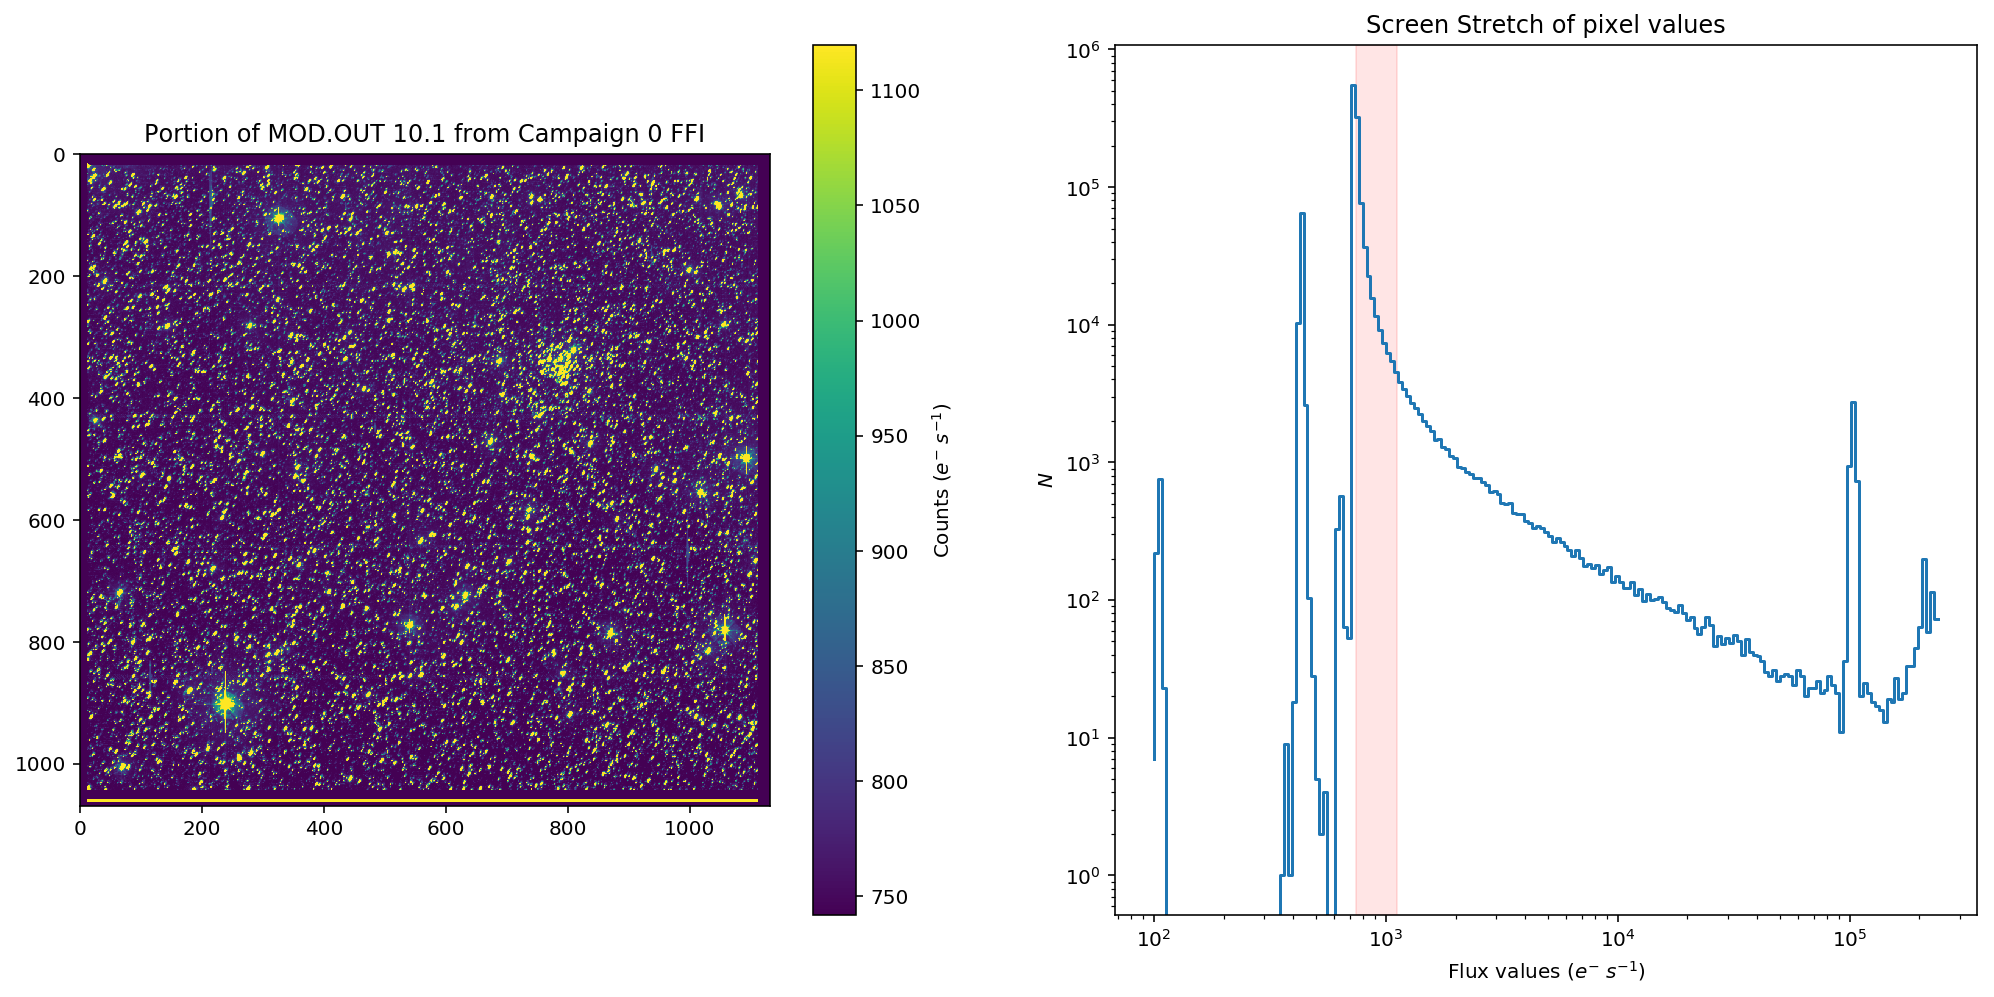

In [19]:
plt.figure(figsize=(17,8))

plt.subplot(121)
plt.imshow(data, norm=norm)
plt.title('Portion of {} from Campaign {} FFI'.format(mod_out, str(campaign)))
cbar = plt.colorbar()
cbar.set_label('Counts ($e^{-} \; s^{-1}$)')

plt.subplot(122)
plt.step(10**x, y)
plt.axvspan(10**vmin, 10**vmax, alpha=0.1, color='r')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Flux values ($e^{-} \; s^{-1}$)')
plt.ylabel('$N$')
plt.title('Screen Stretch of pixel values');

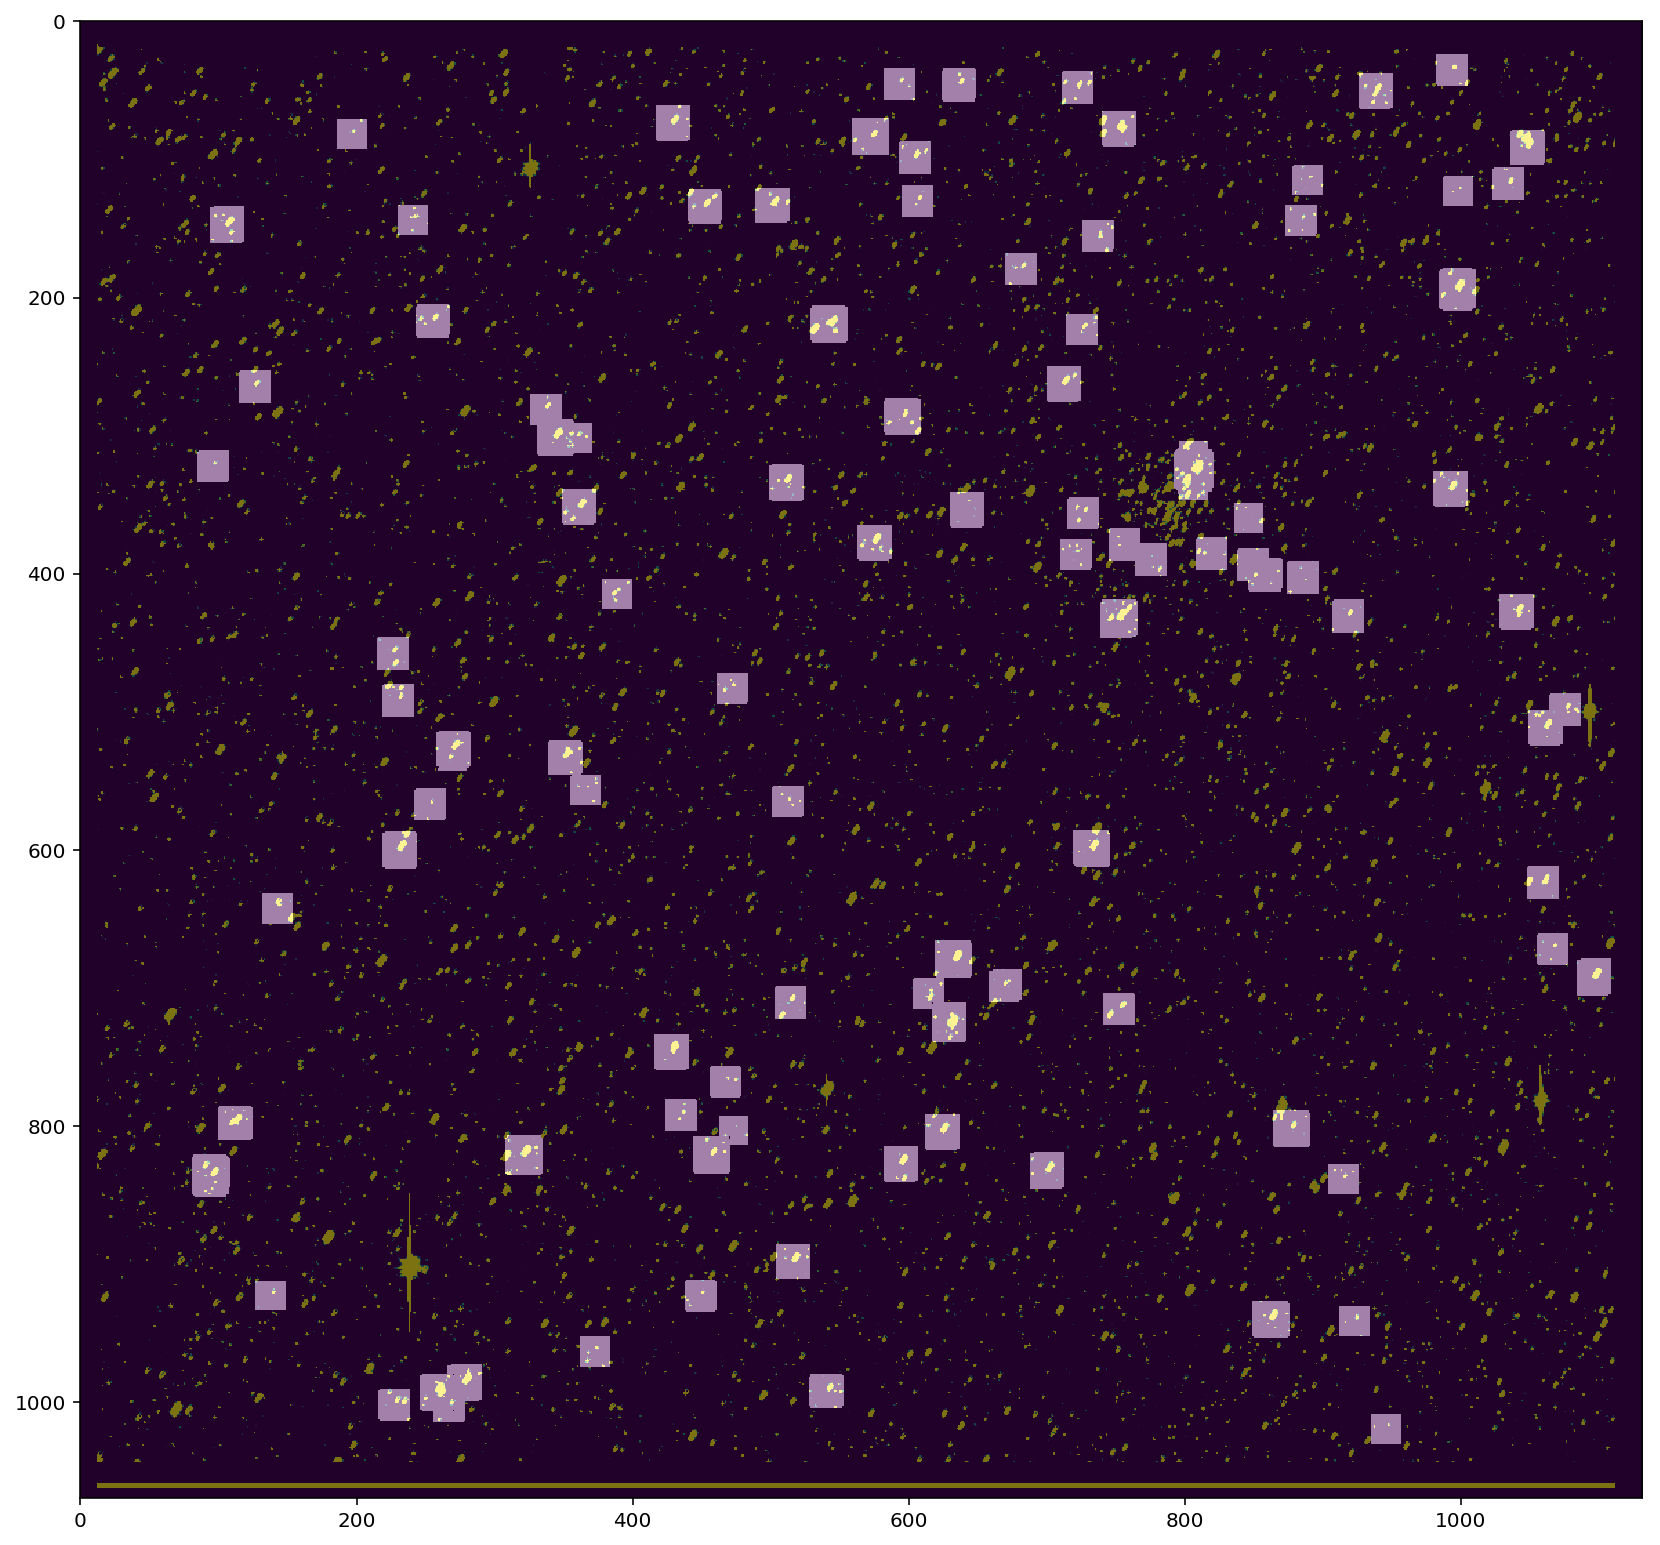

In [20]:
plt.figure(figsize=(14,14))
plt.imshow(hdu_counts[mod_out].data, interpolation='none', cmap='binary_r');
plt.imshow(hdu_ffi[mod_out].data, alpha=0.5, interpolation='none', cmap='viridis', norm=norm);

First, let's spotcheck if the alignment is correct!

In [21]:
df['mod_str'] = "MOD.OUT "+df.module.astype(str)+'.'+df.output.astype(str)

In [22]:
gi = (df.campaign == campaign) & (df.mod_str == mod_out)

In [23]:
df = df.reset_index(drop=True)

In [24]:
local_dir = '/Volumes/burlingame/TPFs/c{}/'.format(campaign)
mod_out_tpfs = df.url[gi].str[59:].values

In [25]:
len(mod_out_tpfs)

101

In [26]:
ii = 20

In [27]:
#df.npix[gi]

In [28]:
df.npix[gi].sort_values().tail(15)

163890     722
166407     722
163214     722
167508     723
163203     725
163204     725
163370     725
167117     725
166836     725
162936     729
163316     748
166215     777
166972     821
167913     846
166970    1140
Name: npix, dtype: int64

In [29]:
#tpf_path = mod_out_tpfs[ii]
tpf_path = df.url.loc[166970][59:]
hdu_tpf = fits.open(local_dir+tpf_path)

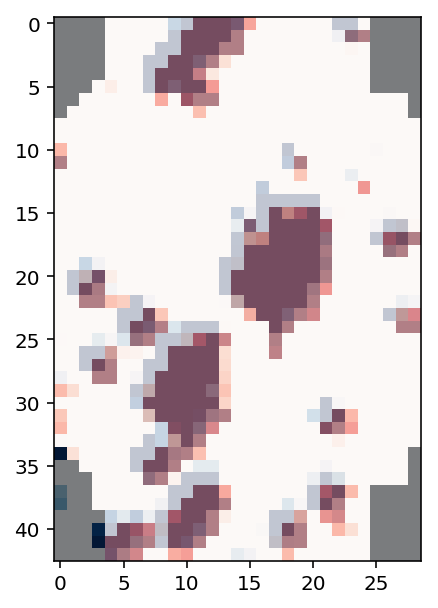

In [77]:
plt.figure(figsize=(5,5))
hdr = hdu_tpf['TARGETTABLES'].header
cx, cy = hdr['1CRV4P'], hdr['2CRV4P']
sy, sx = hdu_tpf['APERTURE'].shape

plt.imshow(hdu_counts[mod_out].data[cy:cy+sy, cx:cx+sx], interpolation='none', cmap='binary_r');
#plt.imshow(hdu_counts[mod_out].data, interpolation='none', cmap='binary_r');
plt.imshow(hdu_ffi[mod_out].data[cy:cy+sy, cx:cx+sx], alpha=0.5, interpolation='none', cmap='Blues', norm=norm);
plt.imshow(hdu_tpf['TARGETTABLES'].data['FLUX'][0, :, :], alpha=0.5, interpolation='none', cmap='Reds', norm=norm);

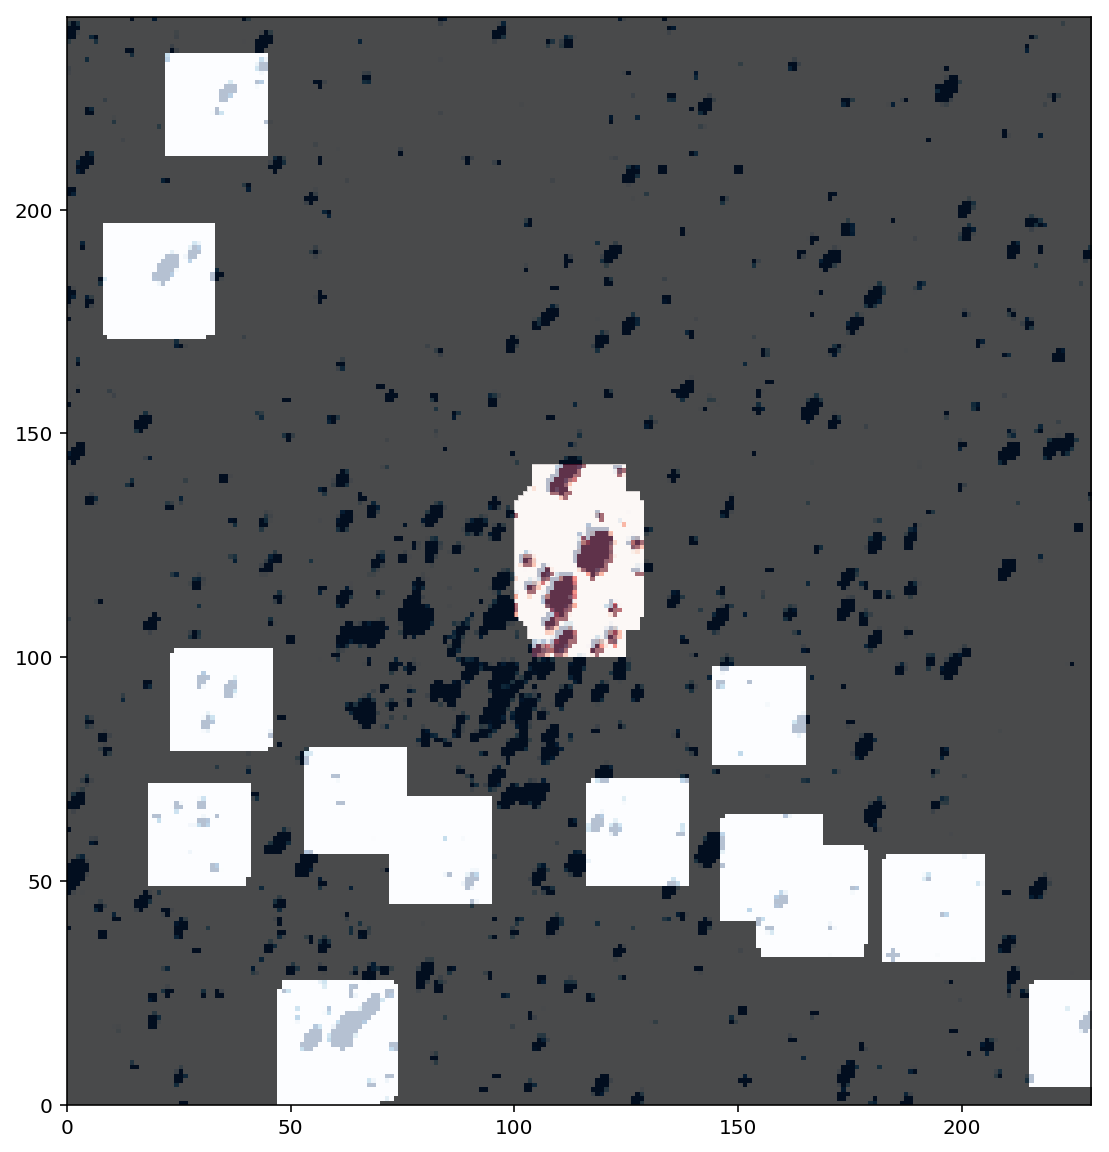

In [76]:
plt.figure(figsize=(10,10))
hdr = hdu_tpf['TARGETTABLES'].header
cx, cy = hdr['1CRV4P']x, hdr['2CRV4P']
sy, sx = hdu_tpf['APERTURE'].shape

dx = 100
dy=100
plt.imshow(hdu_counts[mod_out].data[cy-dx:cy+sy+dx, cx-dx:cx+sx+dx], interpolation='none', cmap='binary_r', extent=[0, 200+sx, 0, 200+sy]);
#plt.imshow(hdu_counts[mod_out].data, interpolation='none', cmap='binary_r');

extent = [dx,dx+sx, dy, dy+sy]
plt.imshow(hdu_tpf['TARGETTABLES'].data['FLUX'][500, :, :], alpha=0.8, extent=extent, interpolation='none', cmap='Reds', norm=norm);
plt.imshow(hdu_ffi[mod_out].data[cy-dx:cy+sy+dx, cx-dx:cx+sx+dx], alpha=0.3, interpolation='none', cmap='Blues', norm=norm, extent=[0, 200+sx, 0, 200+sy]);

The end